In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import bisect

%matplotlib inline

In [2]:
np.random.seed(17)

# Interpolation

![](http://cloud.originlab.com/images/WikiWeb/Mathematics/2D_Interpolation_On_Matrix.png?v=6026)

In [3]:
def rand(n, a=0.5, sigma=200):
    return (np.random.rand(n) - a) * sigma

In [4]:
def apply(f, X):
    return np.array([f(x) for x in X])

In [5]:
def poly(a):
    return lambda x: np.dot(a, [x ** i for i in range(len(a))])

In [6]:
def sub_plot(ax, f, x, bounds, *methods):
    y = apply(f, x)
    gs = [method(x, y) for method in methods]
    
    points = np.linspace(*bounds, num=100)
    ax.plot(points, apply(f, points), label=f.__name__)
    for i in range(len(methods)):
        ax.plot(points, apply(gs[i], points), label=methods[i].__name__)
    ax.plot(x, y, 'ro')
    ax.set_title(" vs ".join([method.__name__.capitalize() for method in methods]) + " interpolation. " + \
                 str(len(x)) + " knots.")
    ax.legend(loc="upper left")

In [7]:
def plot(f, x, bounds, *methods):
    figure, ax = plt.subplots(figsize=(15, 10))
    sub_plot(ax, f, x, bounds, *methods)

## Simple matrix solution

In [8]:
def simple(x, y):
    n = len(x)
    A = np.ones(n)
    c = x.copy()
    for i in range(n - 1):
        A = np.c_[A, c]
        c *= x
    return poly(np.linalg.solve(A, y))

## Cubic vs quadratic

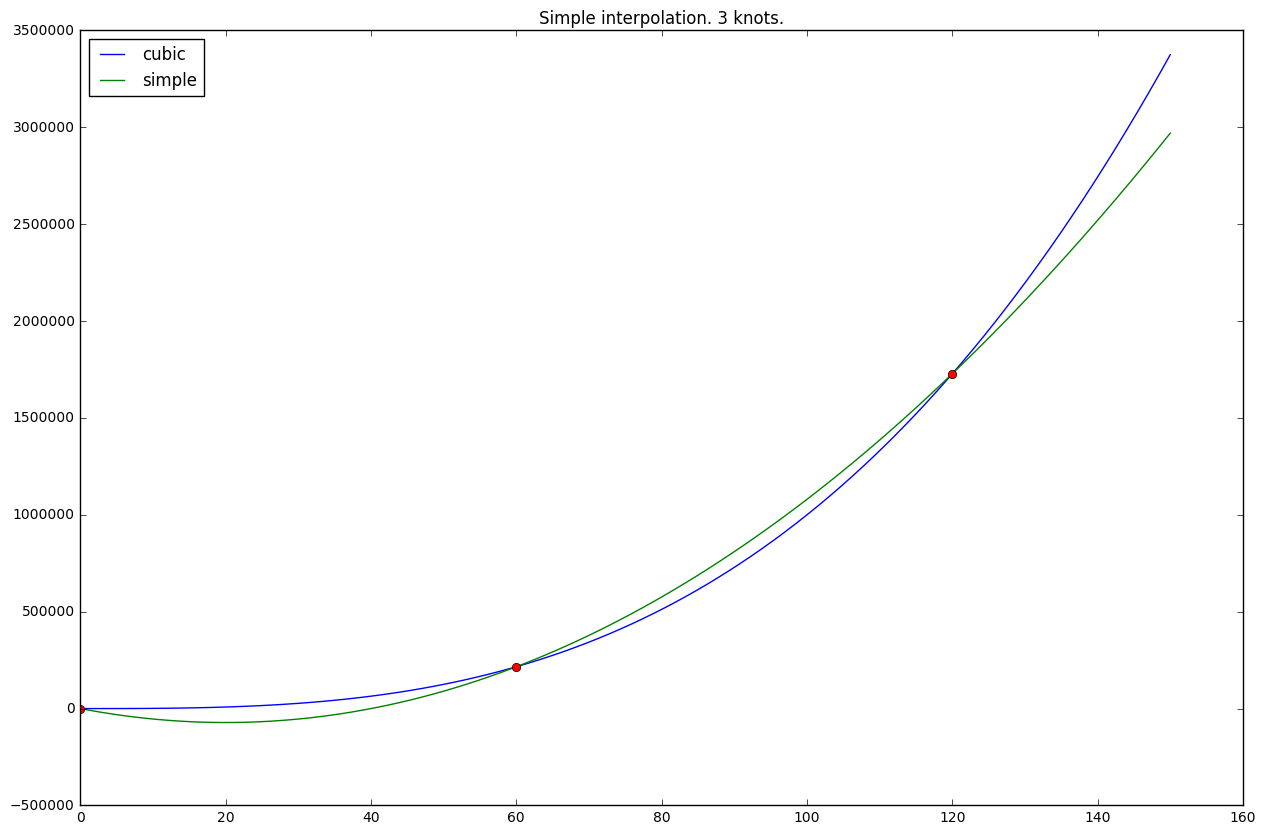

In [9]:
def cubic(x):
    return x**3

plot(cubic, np.linspace(0, 120, num=3), (0, 150), simple)

## Random polynomials

In [10]:
def random_poly(n):
    a = rand(n + 1)
    f = poly(a)
    f.__name__ = str(n) + "-poly"
    return f

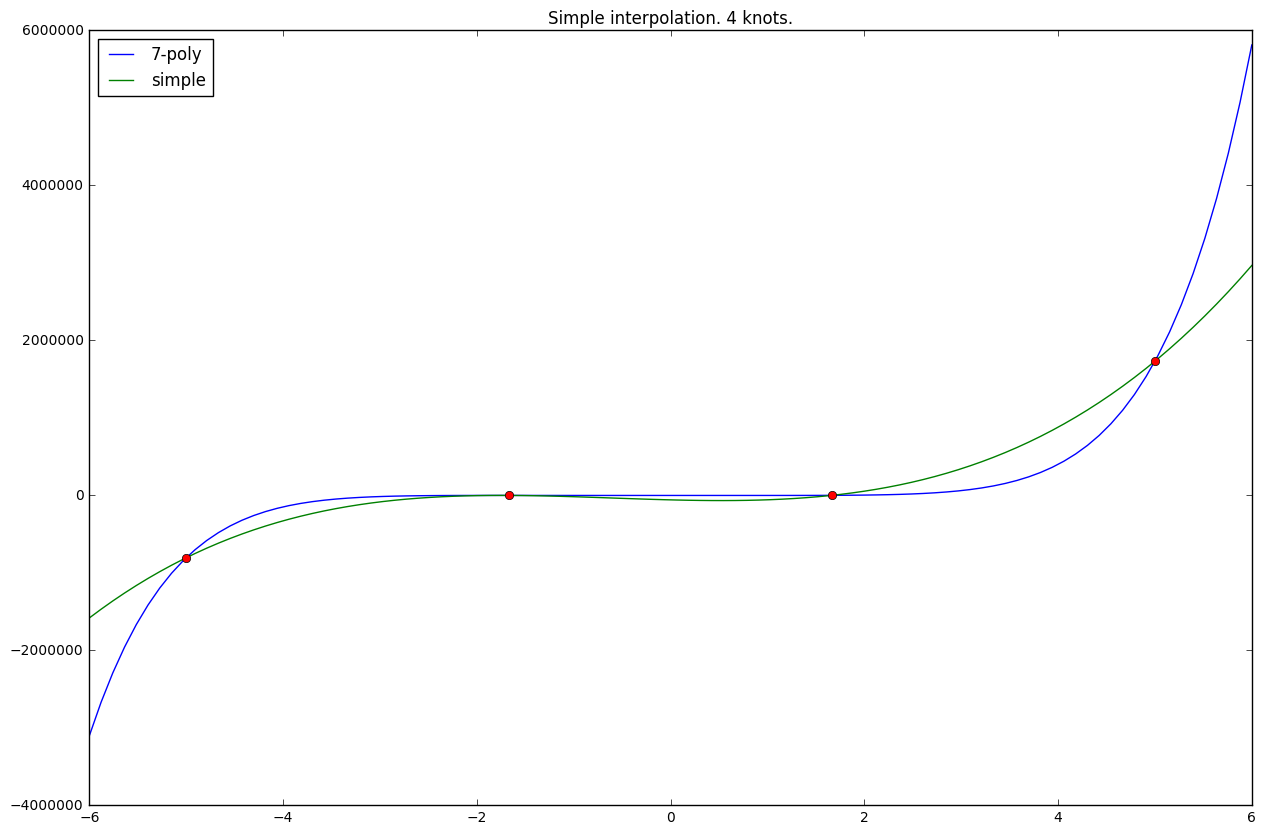

In [11]:
plot(random_poly(7), np.linspace(-5, 5, num=4), (-6, 6), simple)

## Full match

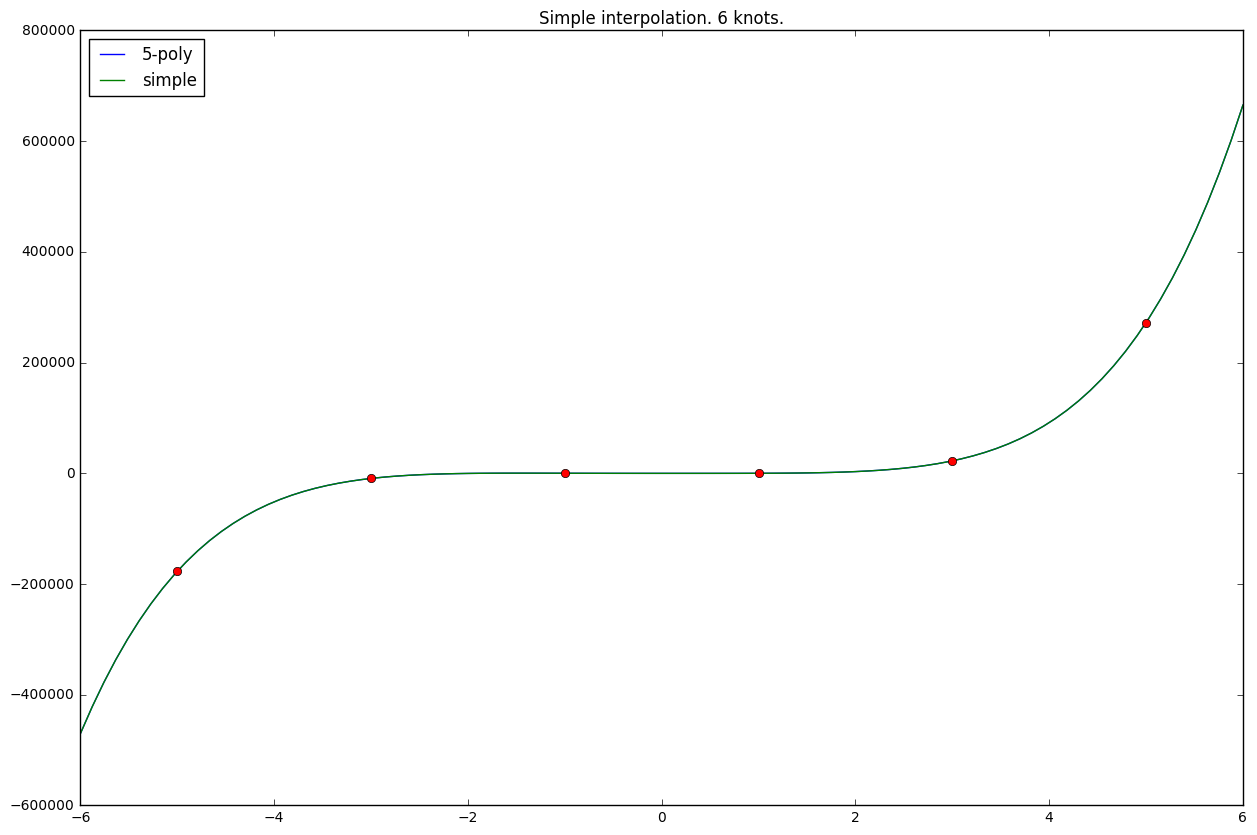

In [12]:
plot(random_poly(5), np.linspace(-5, 5, num=6), (-6, 6), simple)

## Lagrange polynomial

In [13]:
def lagrange(x, y, verbose=False):
    n = len(x)
    t = sp.Symbol("t")
    res = 0
    for i in range(n):
        c = 1
        for j in range(n):
            if j != i:
                c *= (t - x[j]) / (x[i] - x[j])
        res += y[i] * c
    res = sp.simplify(res)
    if not verbose:
        print("f(t) =", res)
    return lambda x: res.subs(t, x)

f(t) = 7451.7059898207*t**3 - 28486.9592741477*t**2 - 20685.7505042266*t + 78176.925161777


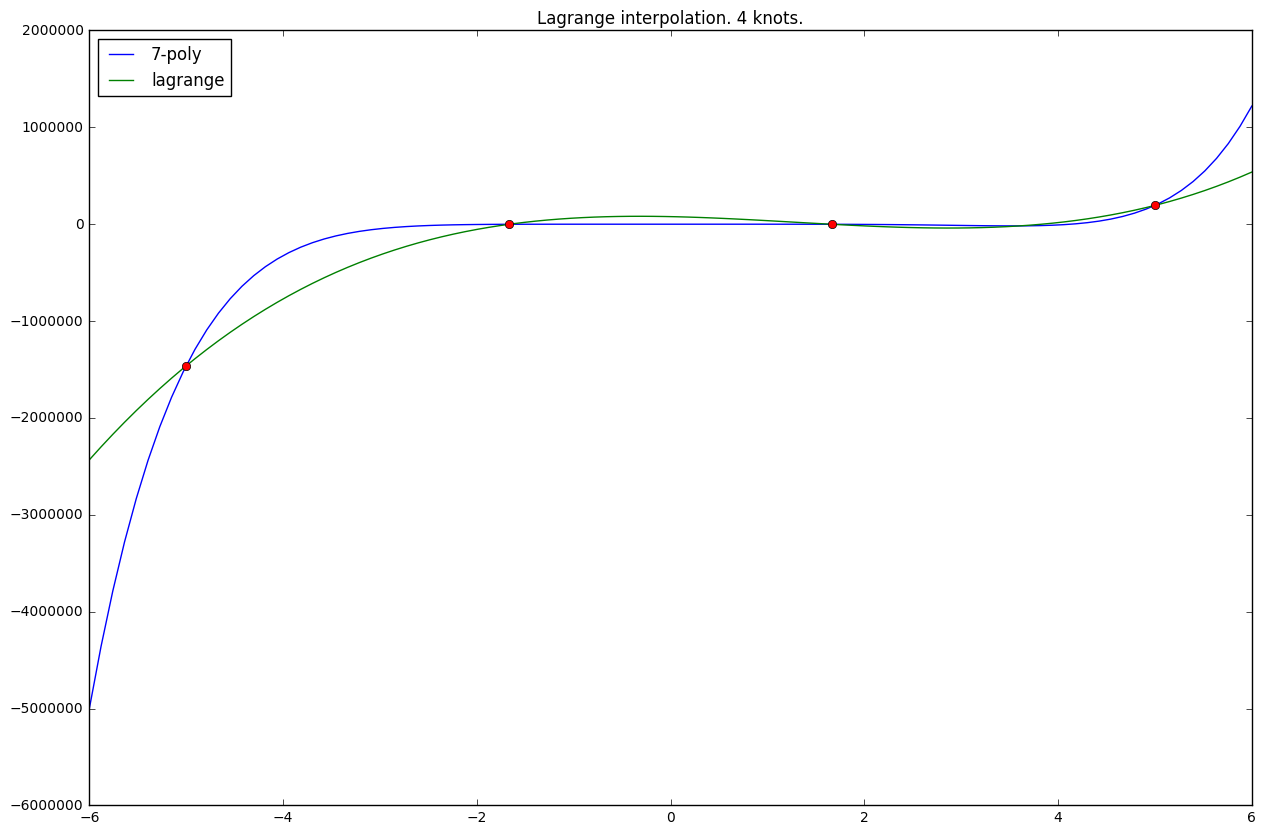

In [14]:
plot(random_poly(7), np.linspace(-5, 5, num=4), (-6, 6), lagrange)

## Divided differences

In [15]:
def divided_differences(x, y):
    n = len(x)
    M = np.zeros((n, n))
    M[0, :] = y
    for i in range(1, n):
        for k in range(n - i):
            M[i][k] = (M[i - 1][k + 1] - M[i - 1][k]) / (x[k + i] - x[k])
    return M

In [16]:
divided_differences(np.array([0, 1, 2, 3]), np.array([0, 1, 8, 27]))

array([[  0.,   1.,   8.,  27.],
       [  1.,   7.,  19.,   0.],
       [  3.,   6.,   0.,   0.],
       [  1.,   0.,   0.,   0.]])

## Newton polynomial

In [17]:
def newton(x, y, verbose=False):
    n = len(x)
    diff = divided_differences(x, y)
    t = sp.Symbol("t")
    res = 0
    for i in range(n):
        c = diff[i][0]
        for j in range(i):
            c *= t - x[j]
        res += c
    res = sp.simplify(res)
    if not verbose:
        print("f(t) =", res)
    return lambda x: res.subs(t, x)

f(t) = -31707.4103876758*t**3 + 28663.7103445788*t**2 + 86359.4210401191*t - 79291.5600740521


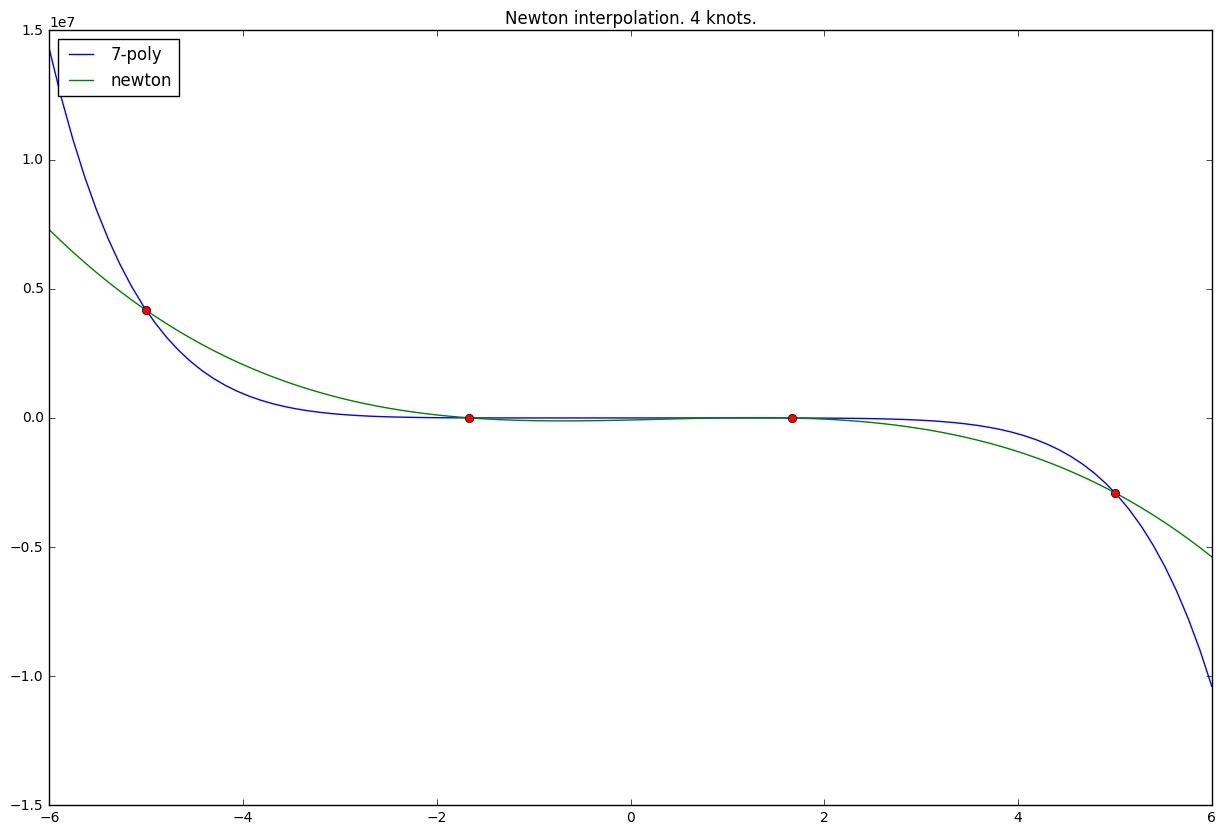

In [18]:
plot(random_poly(7), np.linspace(-5, 5, num=4), (-6, 6), newton)

## Cubic spline interpolation

In [19]:
def spline(x, y, verbose=True):
    x = np.copy(x)
    x.sort()
    n = len(x) - 1
    A = np.zeros((4 * n, 4 * n))
    z = np.zeros(4 * n)
    k = 0
    # left knots
    for i in range(n):
        A[k][4*i] = 1
        A[k][4*i + 1] = x[i]
        A[k][4*i + 2] = x[i] ** 2
        A[k][4*i + 3] = x[i] ** 3
        z[k] = y[i]
        k += 1
    # rights knots
    for i in range(n):
        A[k][4*i] = 1
        A[k][4*i + 1] = x[i + 1]
        A[k][4*i + 2] = x[i + 1] ** 2
        A[k][4*i + 3] = x[i + 1] ** 3
        z[k] = y[i + 1]
        k += 1
    # first derivative
    for i in range(n - 1):
        A[k][4*i + 1] = 1
        A[k][4*i + 2] = 2 * x[i + 1]
        A[k][4*i + 3] = 3 * x[i + 1] ** 2
        A[k][4*i + 5] = -1
        A[k][4*i + 6] = -2 * x[i + 1]
        A[k][4*i + 7] = -3 * x[i + 1] ** 2
        k += 1
    # second derivative
    for i in range(n - 1):
        A[k][4*i + 2] = 2
        A[k][4*i + 3] = 6 * x[i + 1]
        A[k][4*i + 6] = -2
        A[k][4*i + 7] = -6 * x[i + 1]
        k += 1
    A[k][2] = 2
    A[k][3] = 6 * x[0]
    k += 1
    A[k][4*(n - 1) + 2] = 2
    A[k][4*(n - 1) + 3] = 6 * x[n]
    if not verbose:
        print(A)
        print(z)
    c = np.linalg.solve(A, z)
    
    def evaluate(t):
        k = bisect.bisect_right(x, t)
        k -= 1
        if k == -1:
            k = 0
        if k == len(x) - 1:
            k = len(x) - 2
        return c[4*k] + c[4*k + 1] * t + c[4*k + 2] * t**2 + c[4*k + 3] * t**3
    
    return evaluate

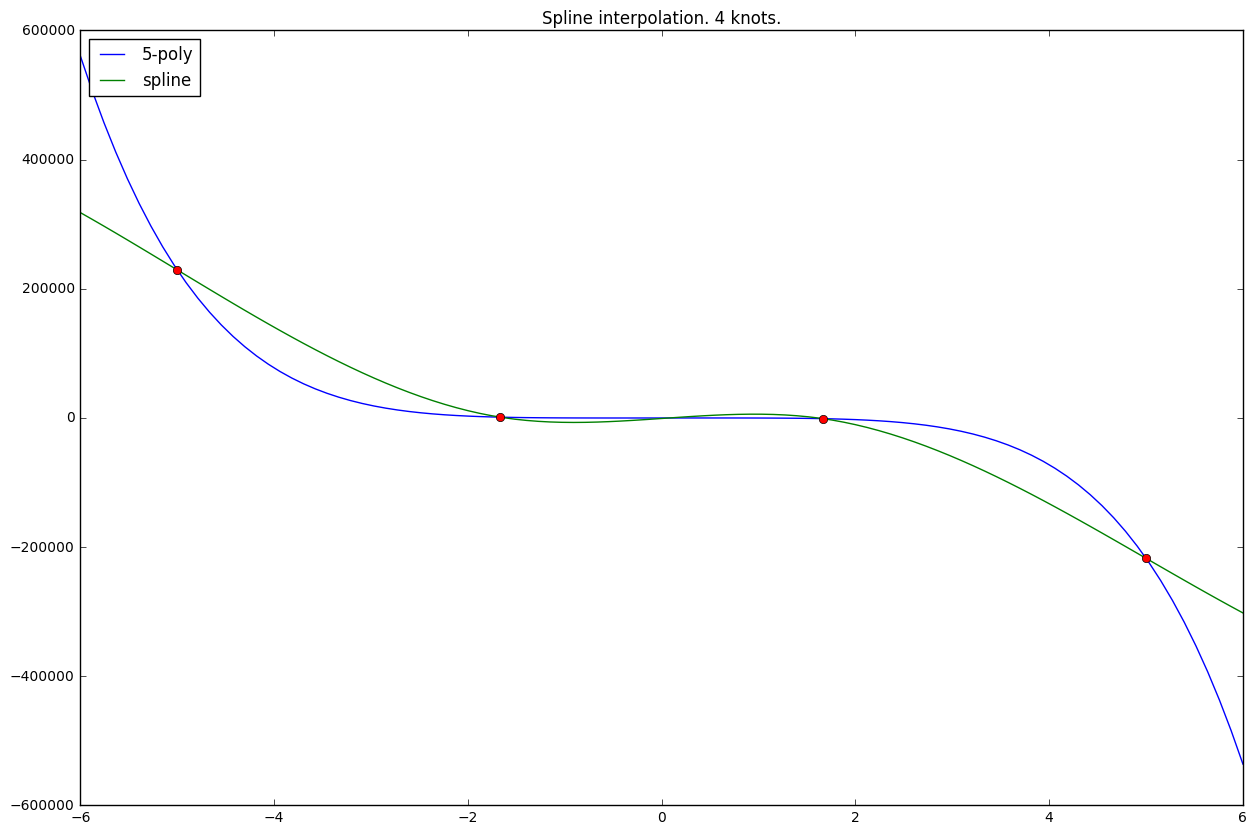

In [20]:
plot(random_poly(5), np.linspace(-5, 5, num=4), (-6, 6), spline)

## Poly vs Spline

In [30]:
def knot_count_plot(f, knots, xrange, bounds, *methods):
    figure, axs = plt.subplots(len(knots), figsize=(15, len(knots) * 5))
    for i in range(len(knots)):
        x = np.linspace(*xrange, num=knots[i])
        sub_plot(axs[i], f, x, bounds, *methods)

f(t) = 1244.09143573175*t + 48060.2193244606
f(t) = 1919.33785923656*t**2 + 1244.09143573175*t + 76.7728435466474
f(t) = 53.6380878856625*t**3 + 2126.02885143276*t**2 - 96.8607614098119*t - 5090.5019613585
f(t) = 74.4087571906341*t**4 + 53.6380878856624*t**3 + 59.118929470705*t**2 - 96.8607614098111*t + 76.7728435466474


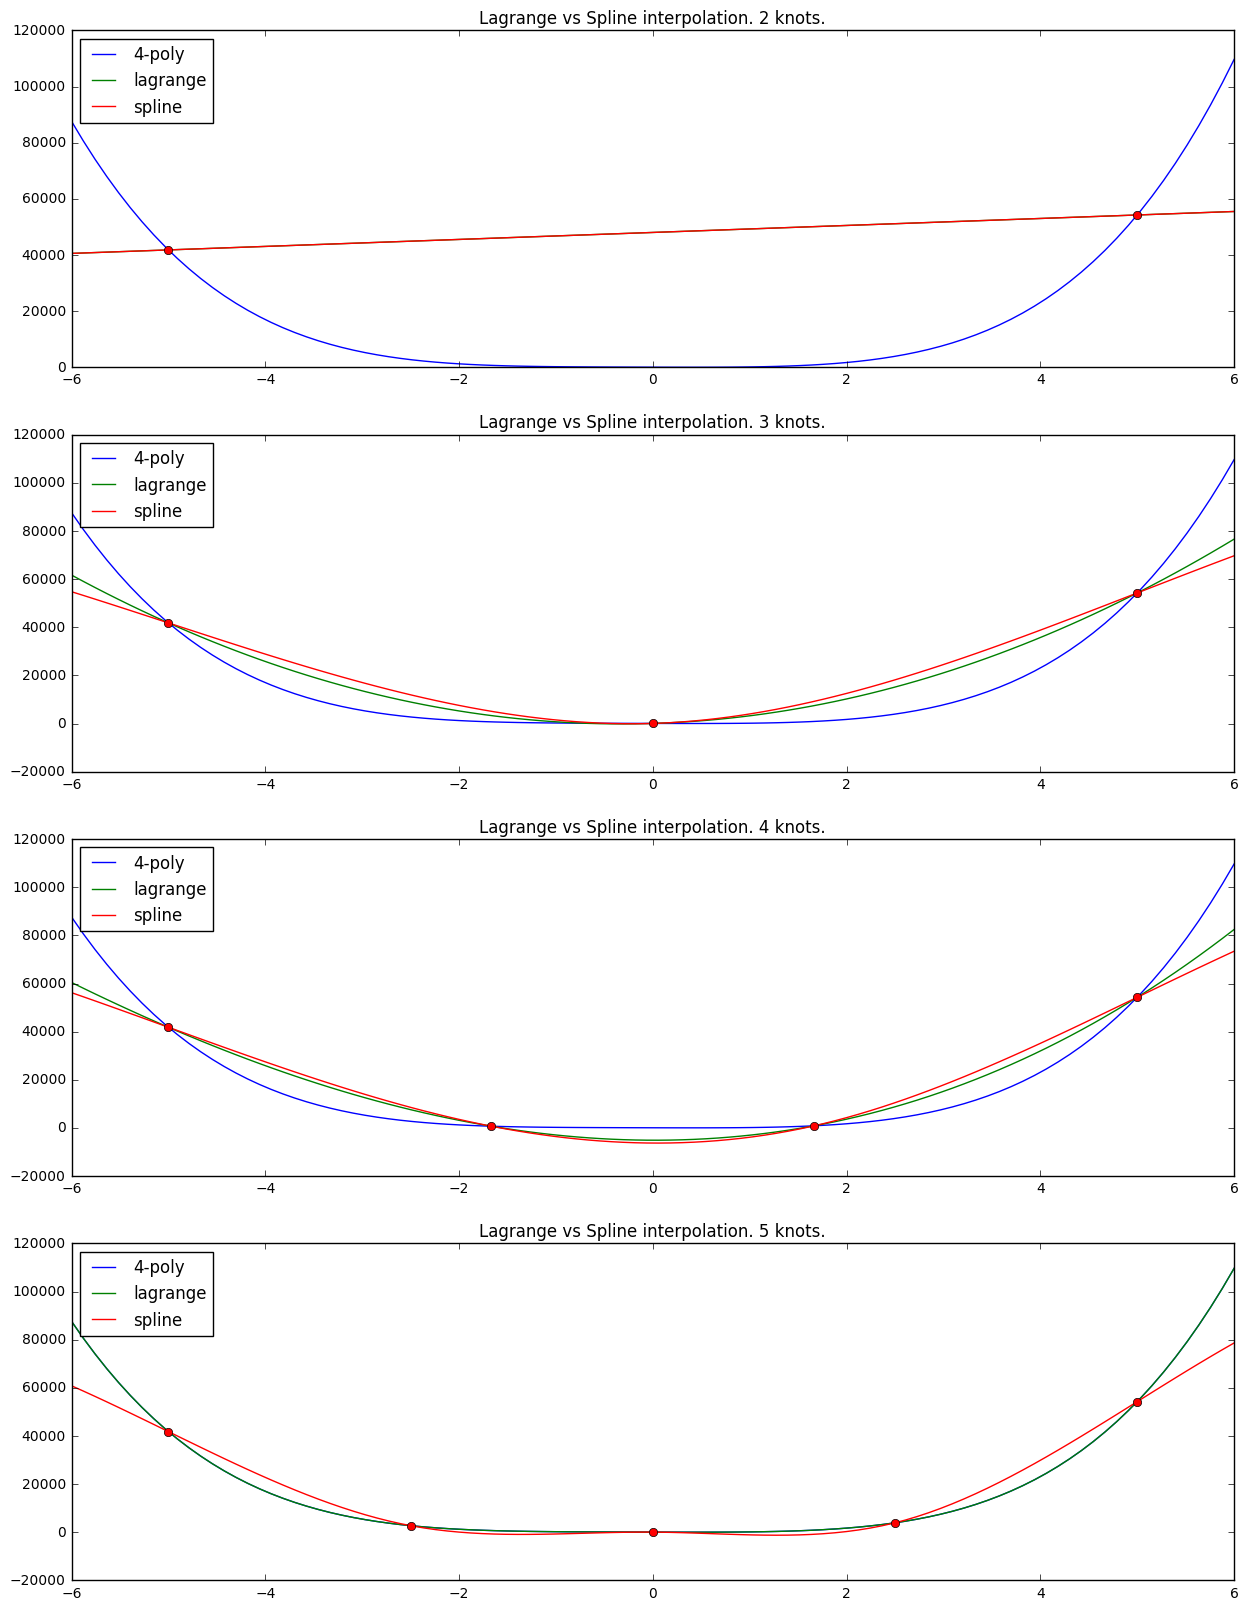

In [31]:
knot_count_plot(random_poly(4), np.arange(2, 6), (-5, 5), (-6, 6), lagrange, spline)

## Something more interesting?

f(t) = -0.191784854932628*t
f(t) = -0.191784854932628*t
f(t) = -0.0355063333312659*t**3 + 0.69587347834902*t - 2.08166817117217e-16
f(t) = t*(-4.33680868994202e-19*t**3 - 0.0229959313372912*t**2 - 1.38777878078145e-17*t + 0.383113428499653)
f(t) = 0.0035157216318315*t**5 - 8.67361737988404e-19*t**4 - 0.134461089083474*t**3 + 2.77555756156289e-17*t**2 + 0.972416352259539*t - 1.11022302462516e-16


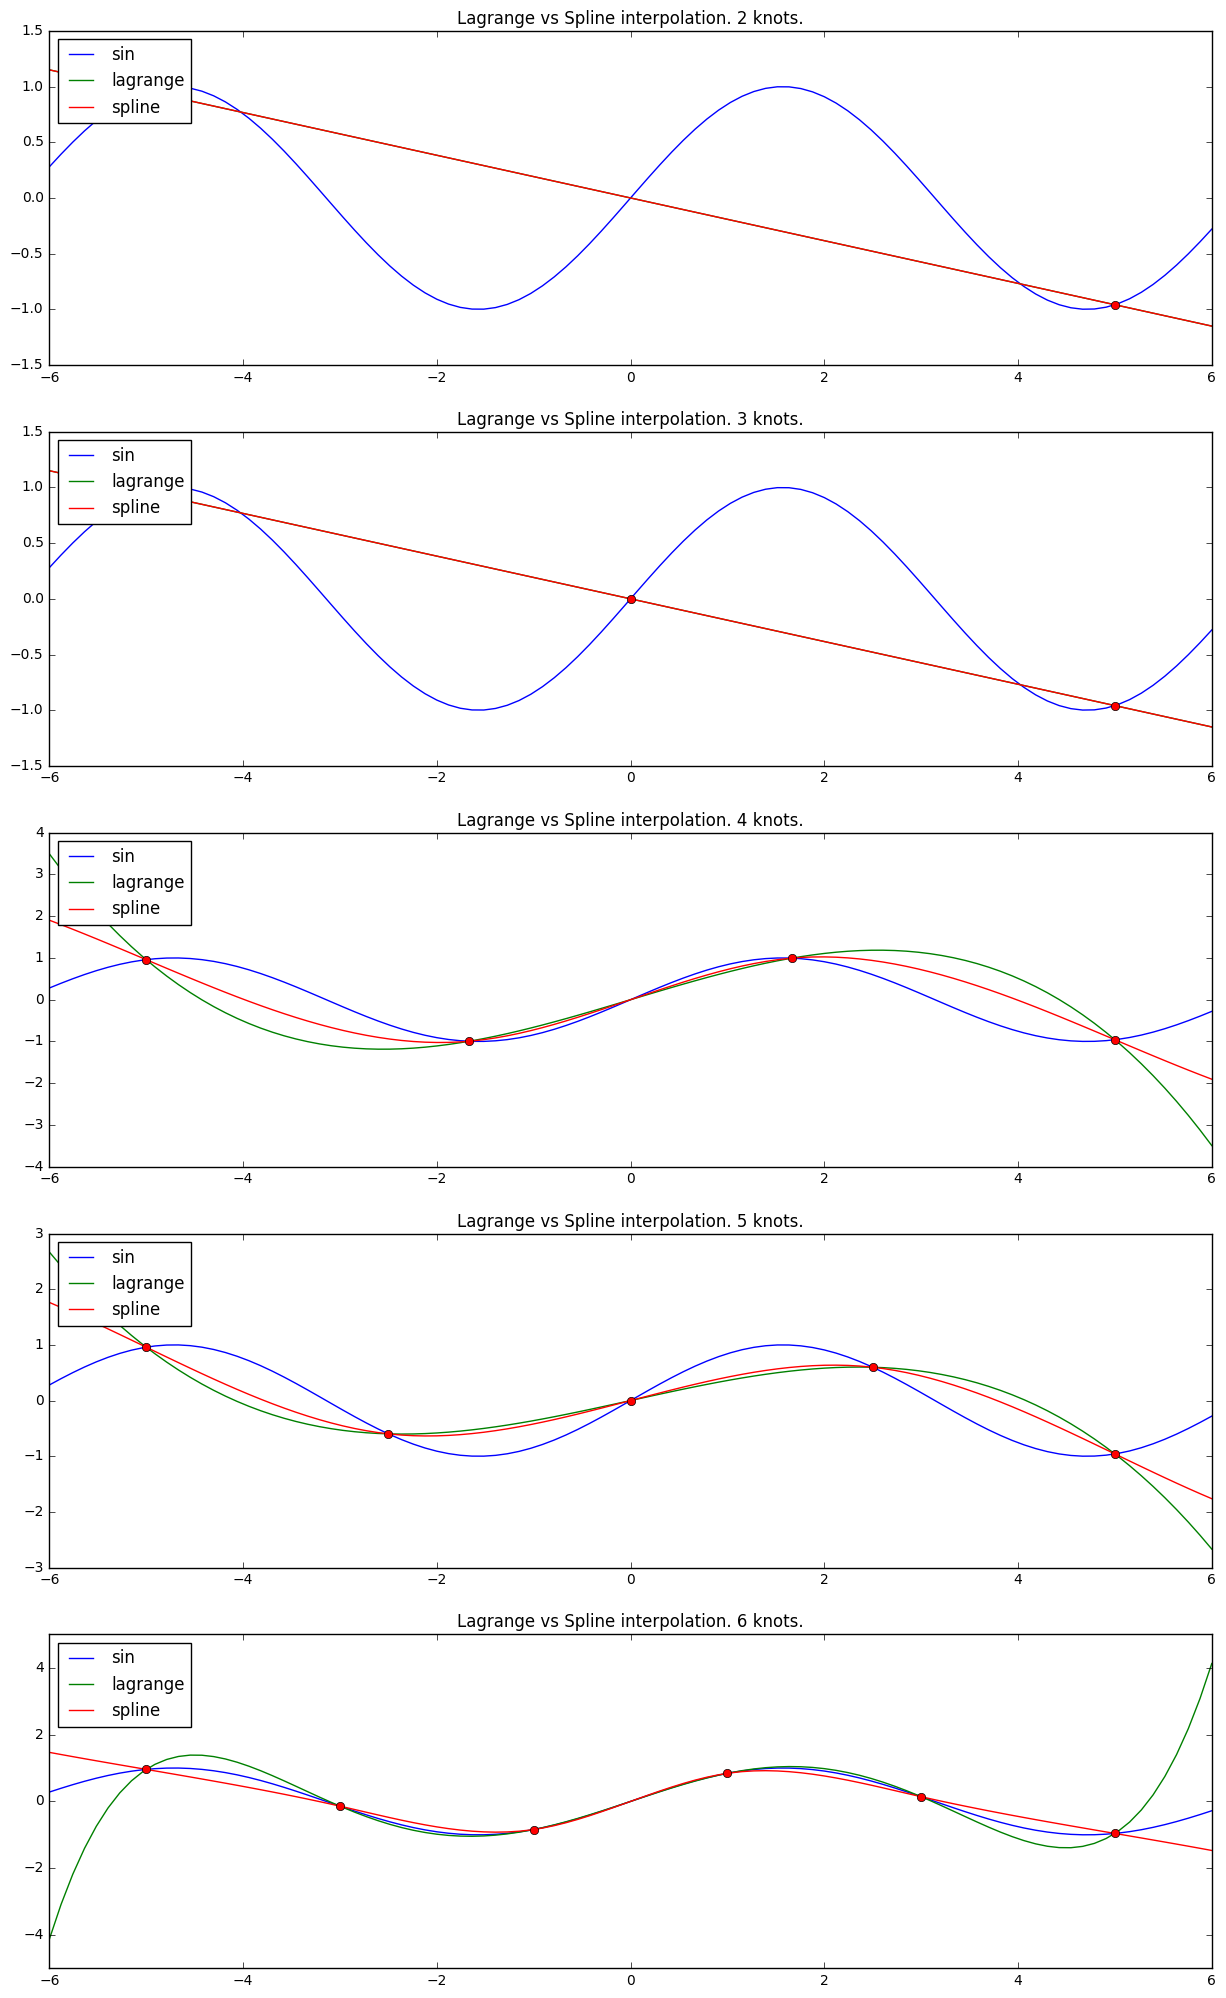

In [33]:
knot_count_plot(np.sin, np.arange(2, 7), (-5, 5), (-6, 6), lagrange, spline)

In [34]:
def xsinx(x):
    return x * np.sin(x)

f(t) = -0.54402111088937*t
f(t) = t*(0.0829806327547538*t - 1.37382743843691)
f(t) = t*(-0.0667301190708283*t**2 + 0.836716948742295*t - 2.23817869122949)
f(t) = t*(-0.0728881707659409*t**3 + 1.36966821510551*t**2 - 7.70661270978826*t + 12.443455242383)


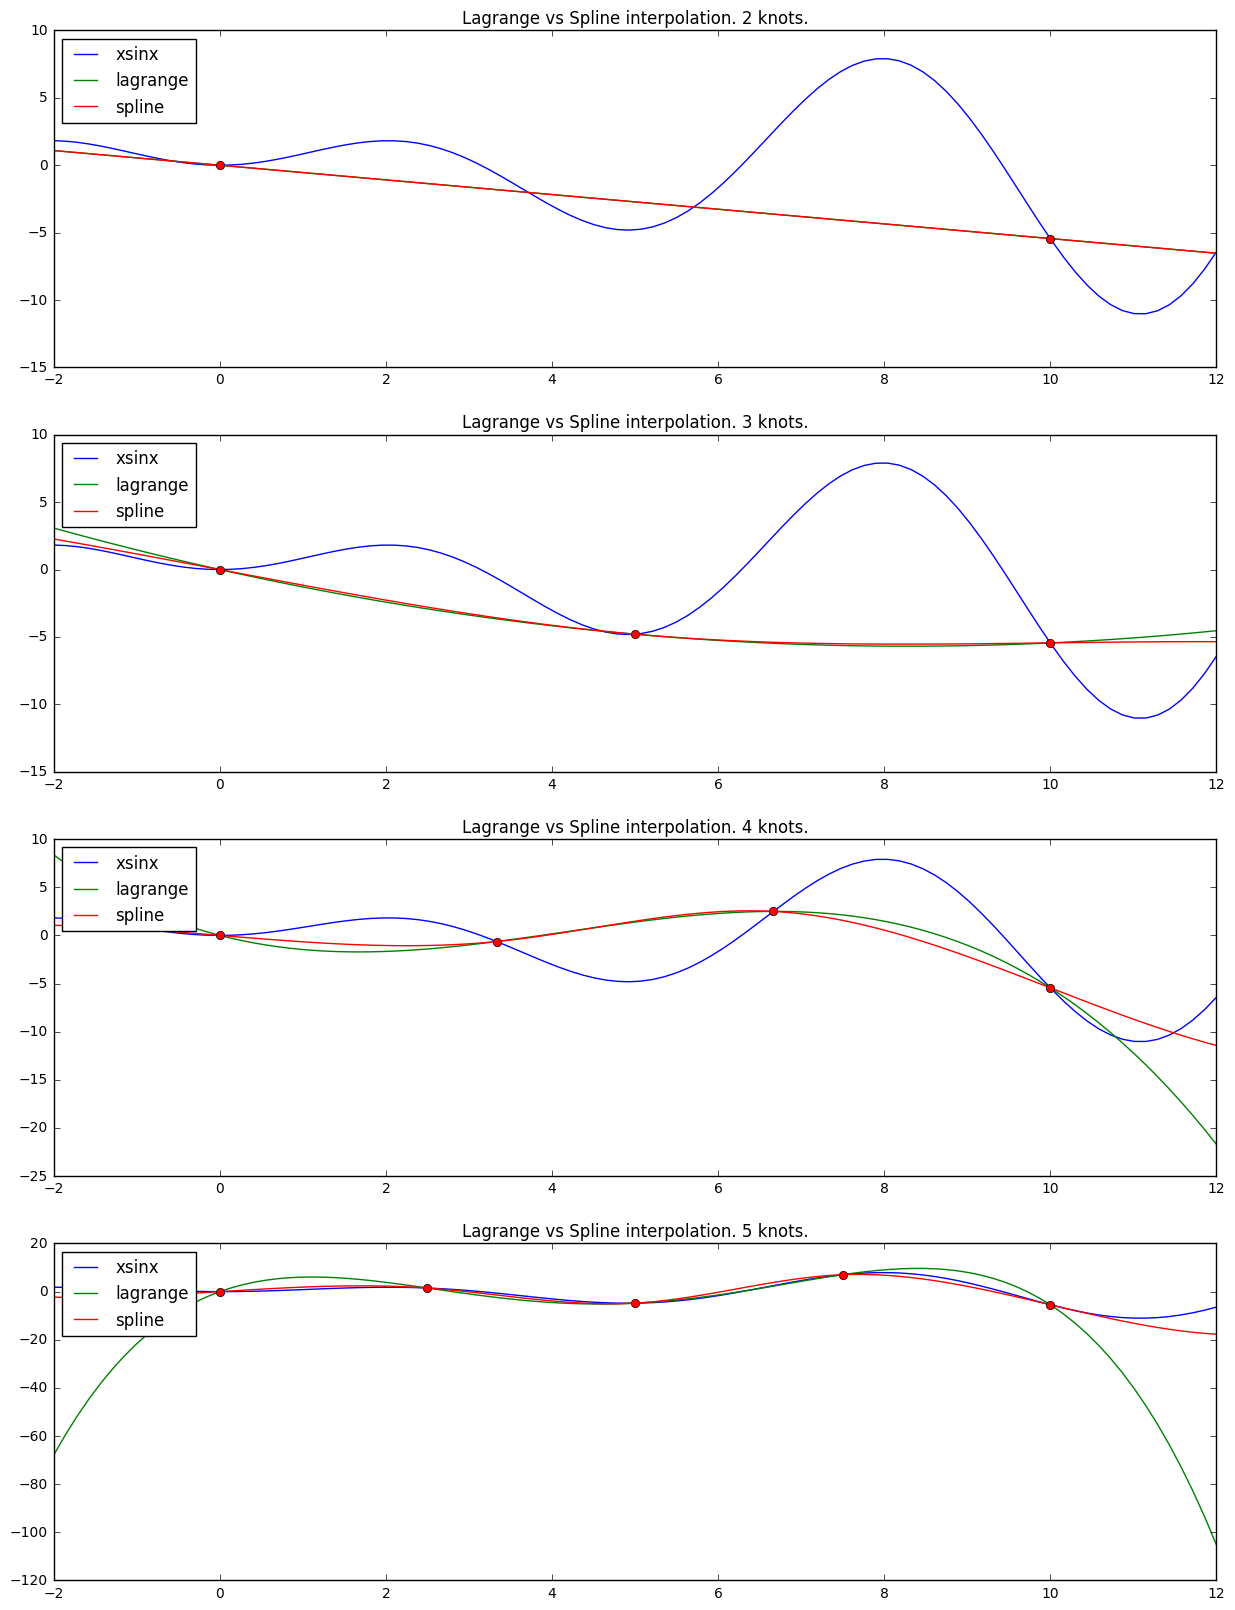

In [39]:
knot_count_plot(xsinx, np.arange(2, 6), (0, 10), (-2, 12), lagrange, spline)